In [1]:
import torch
from IPython import display
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [3]:
 # 上一次分享中实现的FashionMnist数据读取的完整方法
def load_data_fashion_mnist(batch_size, resize=None): 
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    # 训练集
    train_dataset = torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
    train_dataloader = data.DataLoader(train_dataset, batch_size, shuffle=True,num_workers=4)
    # 测试集
    test_dataset = torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)
    test_dataloader = data.DataLoader(test_dataset, batch_size, shuffle=False,num_workers=4)
    return (train_dataloader,test_dataloader)

In [6]:
# 开始读取FashionMnist
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
next(iter(train_iter))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0078, 0.0157,  ..., 0.3922, 0.4392, 0.0078],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [9]:
# 初始化参数
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
W.shape,b

(torch.Size([784, 10]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

In [10]:
# 回忆一下sum运算符如何沿着张量中的特定维度工作
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [12]:
# sofmax运算方法
# softmax(X)ij=exp(Xij)∑kexp(Xik).
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [17]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1119, 0.2579, 0.0352, 0.4932, 0.1017],
         [0.3221, 0.0836, 0.1142, 0.2568, 0.2233]]),
 tensor([1., 1.]))

In [27]:
# 定义模型 Y = WX + b
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [21]:
# 定义损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])


# 具体例子
y = torch.tensor([0, 1])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]
cross_entropy(y_hat, y)


tensor([2.3026, 1.6094])

In [22]:
# 定义优化算法
lr = 0.1

def sgd(params, lr, batch_size): 
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
def updater(batch_size):
    return sgd([W, b], lr, batch_size)

In [23]:
# 分类准确率判断
def accuracy(y_hat, y):
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.0

In [28]:
# 评估模型整体的分类准确率
class Accumulator:  # Accumulator 是一个实用程序类，用于对多个变量进行累加
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 在 Accumulator 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量。当我们遍历数据集时，两者都将随着时间的推移而累加。
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [29]:
evaluate_accuracy(net, test_iter)

0.1352

In [32]:
# 定义train_epoch
def train_epoch(net, train_iter, loss, updater): 
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        # 使用定制的优化器和损失函数
        l.sum().backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

In [30]:
# 定义整体的训练方法：train
def train(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print(epoch+1,train_metrics[0],train_metrics[1],test_acc)
    train_loss, train_acc = train_metrics
    print(train_loss,train_acc)

In [33]:
# 开始训练
num_epochs = 3
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

1 0.7860846399943033 0.7473833333333333 0.7939
2 0.5707991026560465 0.81355 0.812
3 0.5255736220677694 0.8251166666666667 0.7984
0.5255736220677694 0.8251166666666667


torch.Size([256, 1, 28, 28])


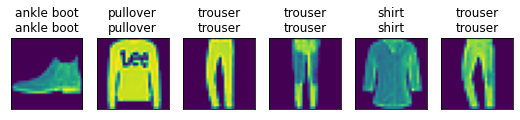

In [34]:
# 预测效果
def predict(net, test_iter, n=6): 
    """预测标签"""
    for X, y in test_iter:
        print(X.shape)
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict(net, test_iter)